In [1]:
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from tqdm import tqdm  # Import tqdm for progress visualization

from numba import njit

import copy

import numpy as np
import scipy as scy
import math as math

from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize

In [2]:
class Box():
    """Box-class: defining a rectangular box-shape, in which Particles can roam. One corner is always (0,0)\n
    box         : 2-dimensional array of the two lengths of the x- and y-axis, corresponding to the boundaries of the box.\n
    particles   : a list of all particles in the box\n
    n_particles : the number of particles inside of the box
    """
    def __init__(self, box_size, n_Particles:int, boundary:bool, rng_seed:int|None=None):
        """Initializing the Box-class\n
        box_size    : a 2-dimensional array of the two lengths of the x- and y-axis, corresponding to the boundaries of the box.\n
        n_Particles : an integer of the number of Particles in the box. Needed to initialize all arrays correctly.\n
        boundary    : Wether the box_borders are hard boundaries.\n
        rng_seed    : Random Number Generator seed for reproducible results. None for random seed.
        """
        # constants
        self.c_6        = 6.2647225     # kg/mol  *  nm**8/ns**2
        self.c_12       = 9.847044e-3   # kg/mol  *  nm**14/ns**2
        self.kB         = 1.380e-23     # J/K
        self.avogadro   = 6.022e23      # 1/mol

        self.box_size       = box_size
        # Particles statistics are no longer stored in a separate class but in arrays, which allows for easier calculations
        self.particles_pos  = np.zeros((n_Particles,2), dtype=float) # shape (n,2)
        self.particles_vel  = np.zeros((n_Particles,2), dtype=float) # shape (n,2)
        self.particles_acc  = np.zeros((n_Particles,2), dtype=float) # shape (n,2)

        # All of the radii stored in an array
        # Additionally the combined raddii are calculated for each pair
        self.particles_r    = np.zeros(n_Particles, dtype=float)
        self.combined_radii = self.particles_r[:,np.newaxis] + self.particles_r[np.newaxis,:] # shape (n,n)

        # All of the masses are stored in an array
        self.particles_m    = np.zeros(n_Particles, dtype=float)
        
        # We use distance matrices for true distances (distances_mat) in x and y coords, 
        # distances with ghost particles for cross boundary calculations (distance_ghost) in x and y coords
        # and the norm of the ghost_distances as a single float
        self.distance_mat   = np.zeros((n_Particles,n_Particles,2), dtype=float)
        self.distance_ghost = np.zeros((n_Particles,n_Particles,2), dtype=float)
        self.distance_abs   = np.zeros((n_Particles,n_Particles), dtype=float)
        self.distance_abs_ghost   = np.zeros((n_Particles,n_Particles), dtype=float)
        # A vectorial force matrix to store the forces between each pair of particles in both directions
        self.force_mat      = np.zeros((n_Particles,n_Particles,2), dtype=float)
        # Storing the energy types currently in the system
        self.potEnergy_mat  = np.zeros((n_Particles,n_Particles), dtype=float)
        self.kinEnergy_mat  = np.zeros((n_Particles), dtype=float)

        # The  current temperatur of the entire system
        self.temp:float = 0. # K
        # The number of particles as an int
        self.n_particles:int = n_Particles
        # Wether a boundary at the edge of the box exists:
        self.boundary = boundary

        # Random Number Generator used with seed
        self.rng = np.random.default_rng(seed=rng_seed)


    def __repr__(self):
        """printing for debugging"""
        return str("This is a box of size %0.2f by %0.2f" % (self.box_size[0],self.box_size[1]) + ", with %0.2f" % (self.n_particles) + " particles")



    def random_positions(self, axis, n_particles = 0) -> None:
        """return random positions for a number of particles (only one axis)\n
        axis        : either 0 or 1.     0 = x-axis, 1 = y-axis\n
        n_particles : the number of particles for which positions should be given; default self.n_particles\n
        returns     : array of random positions
        """
        if n_particles == 0:
            n_particles = self.n_particles
        rnd = np.random.rand(n_particles)*(self.box_size[axis]-0.5)
        return rnd

    def fixedtemp_velocities(self, target_temp):
        """Calculate initial velocities, so that the initial kinetic energy corresponds to a target temperature"""
        self.temp = target_temp
        kin_energy = self.kB * target_temp
        velocities = np.sqrt(2 * (kin_energy/self.n_particles) / (self.particles_m / self.avogadro))
        return velocities

    def fill_particles(self, radius, mass, vel, angle = [], x = [], y = [], align = 'random', grid = np.zeros(2), target_temp:float = 300) -> None:
        """fills the particles-array with particles\n
        radius      : The radius of particles; either as array of length n for individual radii or int/float for a general radius\n
        vel         : The absolute velocity; either as array of length n for individual velocities or int/float for a uniform initial velocity\n
        angle       : The initial angles of the particles as array of length n for individual angles; default is uniformly distributed\n
        x,y         : initial positions as array of length n; default random positions 0.5 away from border; Only used when align = 'defined'\n
        align       : Type of Particle placement: random = random positions; grid = grid-like arrangement(needs corresponding grid argument); defined = as given by x,y input\n
        grid        : 2x2 array that defines how many Particles should be in the grid on the x- and y- axis. Take care of correct number of particles!
        """
        # filling radius and mass, if given as a number for all particles
        if type(radius) == int or type(radius) == float:
            self.particles_r = np.ones(self.n_particles)*radius
        else:
            self.particles_r = radius
        self.combined_radii = self.particles_r[:,np.newaxis] + self.particles_r[np.newaxis,:]
        if type(mass) == int or type(mass) == float:
            self.particles_m = np.ones(self.n_particles)*mass
        else:
            self.particles_m = mass
            
        # randomize the angles if not given
        if len(angle) == 0:
            angle = np.random.uniform(0,2 * np.pi, self.n_particles)
        # fill velocities if given as a number for all particles
        if type(vel) == int or type(vel) == float:
            vel = np.ones(self.n_particles)*vel
        elif type(vel) == str:
            vel = self.fixedtemp_velocities(target_temp)
        
        # calculate the coressponding velocities
        self.particles_vel[:,0] = np.sin(angle) * vel
        self.particles_vel[:,1] = np.cos(angle) * vel

        """
        Check which alignment method should be choosen and fill the positions accoringly
        """
        if align == 'random':
            self.particles_pos[:,0] = self.random_positions(0,self.n_particles)
            self.particles_pos[:,1] = self.random_positions(1,self.n_particles)
        elif align == 'grid':
            if np.prod(grid) == self.n_particles:
                # This monster is mainly the meshgrid of coordinates, adjusted to be the correct shape.
                # Additionally the entire grid is moved by 0.01 in x and y direction to avoid Particles directly on the edge
                # It is not an error, even if vsCode thinks so
                max_rad = np.max(self.particles_r)+0.01
                self.particles_pos[:,] = np.column_stack(np.array(np.meshgrid(np.linspace(0,self.box_size[0]-max_rad,num=grid[0],endpoint=False),
                                                                              np.linspace(0,self.box_size[1]-max_rad,num=grid[1],endpoint=False),
                                                                              indexing='ij')).reshape(2,self.n_particles)) + max_rad # type: ignore
            else:
                print('ERROR: Grid size does not match number of particles!')
            # self.forces = np.ones((self.n_particles, self.n_particles, 2))-1
        elif align == 'left-grid':
            if np.prod(grid) == self.n_particles:
                # This monster is mainly the meshgrid of coordinates, adjusted to be the correct shape.
                # Additionally, the entire grid is moved by 0.1 in x and y direction to avoid Particles directly on the edge
                # It is not an error, even if vsCode thinks so
                max_rad = np.max(self.particles_r)+0.01
                self.particles_pos[:,] = np.column_stack(np.array(np.meshgrid(np.linspace(0,self.box_size[0]/2-max_rad,num=grid[0],endpoint=False),
                                                                              np.linspace(0,self.box_size[1]-max_rad,num=grid[1],endpoint=False),
                                                                              indexing='ij')).reshape(2,self.n_particles)) + max_rad # type: ignore
            else:
                print('ERROR: Grid size does not match number of particles!')
            # self.forces = np.ones((self.n_particles, self.n_particles, 2))-1
        elif align == 'defined':
            self.particles_pos[:,0] = x
            self.particles_pos[:,1] = y
        

    def move(self, dt:float = 1.0, vel = [], particles = []) -> None:
        """moving the particle in the direction, where the velocity-vector points.\n
        dt          : the time-step moving forward; default = 1\n
        vel         : a velocity vector for moving in that direction during a time-step of one; default = self.vel
        particles   : The particles that should be moved as indices for the position array of this class; default(empty) = all particles
        """
        if len(particles) == 0:
            if len(vel) == 0:
                vel = self.particles_vel
            self.particles_pos += vel*dt
        else:
            if len(vel) == 0:
                vel = self.particles_vel[particles]
            self.particles_pos[particles] += vel*dt

    def wrap_around(self) -> None:
        """For continuous borders, i.e. a particle that exits to the right is entering from the left and vice versa\n
        particles   : Particles, which should be wrapped; default self.particles\n
        returns     : array of particles with new positions
        """
        self.particles_pos = self.particles_pos % self.box_size


        

    def calculate_distance_matrix(self) -> None:
        """Calculates a matrix, containing x and y distances of all particles to all other particles in both directions.\n
        It is by nature not symmetric, but rather the upper triangle is negated and flipped"""
        self.distance_mat = self.particles_pos[np.newaxis, :, :] - self.particles_pos[:, np.newaxis, :] # shape: (n,n,2)
        # The norm is calculated as well as the absolute distance between each Particle pair. Symmetric by nature
        self.distance_abs = np.linalg.vector_norm(self.distance_mat, axis = 2) # shape: (n,n)
        
        if self.boundary:
            # the ghost matrix is calculated to account for interactions that go over the boundary of the box.
            # This is adjusted, if the x or y distances is greater than half the box size, which makes the distance across boundaries shorter
            self.distance_ghost = np.where(self.distance_mat[:, :] > (0.5 * self.box_size), 
                                        self.distance_mat[:, :] - self.box_size, self.distance_mat[:, :]) # shape: (n,n,2)
            self.distance_ghost = np.where(self.distance_ghost[:, :] < -(0.5 * self.box_size), 
                                        self.distance_ghost[:, :] + self.box_size, self.distance_ghost[:, :]) # shape: (n,n,2)
            
            self.distance_abs_ghost = np.linalg.vector_norm(self.distance_ghost, axis = 2) # shape: (n,n)
        


In [3]:
class Langevin(Box):
    def __init__(self, box_size, n_Particles: int, samples, boundary: bool, rng_seed: int | None = None):
        super().__init__(box_size, n_Particles, boundary, rng_seed)

        self.samples = samples

        self.pos = np.zeros((self.n_particles,2,samples+1))
        self.vel = np.zeros((self.n_particles,2,samples+1))


    
    def langevin(self, gamma, delta_t = 1e-6):
        
        
        self.pos[:,:,0] = self.particles_pos
        self.vel[:,:,0] = self.particles_vel

        # calculate the coressponding velocities
        rand_k = self.rng.normal(0,1,(self.n_particles,2,self.samples))

        for i in tqdm(range(self.samples)):
            self.pos[:,:,i+1] = self.pos[:,:,i] + self.vel[:,:,i]*delta_t
            self.vel[:,:,i+1] = self.vel[:,:,i] - (1/self.particles_m[:,np.newaxis])*(gamma*self.vel[:,:,i]
                                                                                      *delta_t - np.sqrt(2*(gamma*self.avogadro)*
                                                                                                         self.kB*self.temp*delta_t)*rand_k[:,:,i])
        

In [4]:
box_size = np.array([10,10])
grid = np.array([5,10])
n_particles = 20
steps = 10000000
time_step = 1e-6

In [5]:
kB = 1.380e-23 # J/K
T = 293.15 #K
gamma = 25 #kg/(mol*ns)
mass = 0.018 #kg/mol
 
avogadro = 6.022e23      # 1/mol

In [6]:
sim = Langevin(box_size=box_size, n_Particles=n_particles, samples=steps, boundary=False, rng_seed=421)

In [7]:
sim.fill_particles(radius=0, mass=0.018, vel='ahsd',align='random', target_temp=T)

In [8]:
sim.langevin(gamma=gamma)

100%|██████████| 10000000/10000000 [02:04<00:00, 80202.23it/s]


2min9s

In [9]:
pos, vel = sim.pos[1], sim.vel[1]

In [10]:
vel

array([[  74.9507989 ,  108.89342227,  109.8279737 , ..., -233.68788777,
        -228.55237067, -224.57911075],
       [  88.97596517,   72.22889496,   73.69407842, ...,  259.71434981,
         278.97812943,  263.95543531]])

single particle calculation:

149951.37it/s

multiple particle calculation with class implementation:

38377.58it/s

In [11]:
time = np.arange(0,(sim.samples+1)*1e-6,1e-6)
time

array([0.000000e+00, 1.000000e-06, 2.000000e-06, ..., 9.999998e+00,
       9.999999e+00, 1.000000e+01])

In [12]:
# DO NOT USE WITH MANY PARTICLES. EATS YOUR MEMORY
'''
# Define the age-based colors
norm = Normalize(vmin=0, vmax=time[-1])  # Normalize based on number of points
cmap = plt.cm.magma_r  # Choose a colormap

# Plot using LineCollection
fig, ax = plt.subplots()


for i in range(sim.pos.shape[0]):
    print(i)
    # Create segments for the random walk
    points = sim.pos[i].T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)


    # Create a LineCollection
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(time)  # Use indices to colorize
    lc.set_linewidth(2)  # Optional: Adjust line width


    ax.add_collection(lc)


ax.autoscale()  # Adjust plot limits to fit data
ax.set_aspect('equal')

ax.set_xlabel('nm')
ax.set_ylabel('nm')

# Add a colorbar
cbar = plt.colorbar(lc, ax=ax)
cbar.set_label('time [ns]')

plt.title('Langevin Random Walk')
plt.show()'''

"\n# Define the age-based colors\nnorm = Normalize(vmin=0, vmax=time[-1])  # Normalize based on number of points\ncmap = plt.cm.magma_r  # Choose a colormap\n\n# Plot using LineCollection\nfig, ax = plt.subplots()\n\n\nfor i in range(sim.pos.shape[0]):\n    print(i)\n    # Create segments for the random walk\n    points = sim.pos[i].T.reshape(-1, 1, 2)\n    segments = np.concatenate([points[:-1], points[1:]], axis=1)\n\n\n    # Create a LineCollection\n    lc = LineCollection(segments, cmap=cmap, norm=norm)\n    lc.set_array(time)  # Use indices to colorize\n    lc.set_linewidth(2)  # Optional: Adjust line width\n\n\n    ax.add_collection(lc)\n\n\nax.autoscale()  # Adjust plot limits to fit data\nax.set_aspect('equal')\n\nax.set_xlabel('nm')\nax.set_ylabel('nm')\n\n# Add a colorbar\ncbar = plt.colorbar(lc, ax=ax)\ncbar.set_label('time [ns]')\n\nplt.title('Langevin Random Walk')\nplt.show()"

149951.37it/s

122848.82it/s

In [13]:
#plt.scatter(pos[0], pos[1], c=time, cmap = cmap, )

In [18]:
d_r = (sim.pos-sim.pos[:,:,0,np.newaxis])**2/(4*time)

C:\Users\Peter Pain\AppData\Local\Temp\ipykernel_25952\2182126908.py:1: RuntimeWarning: invalid value encountered in divide
  d_r = (sim.pos-sim.pos[:,:,0,np.newaxis])**2/(4*time)


In [48]:
d_r.shape

(20, 2, 10000001)

In [19]:
x_mean = np.mean(d_r[:,0], axis=0)
y_mean = np.mean(d_r[:,1], axis=0)

x_std = np.std(d_r[:,0], axis=0)
y_std = np.std(d_r[:,1], axis=0)

colours = ['r','k']

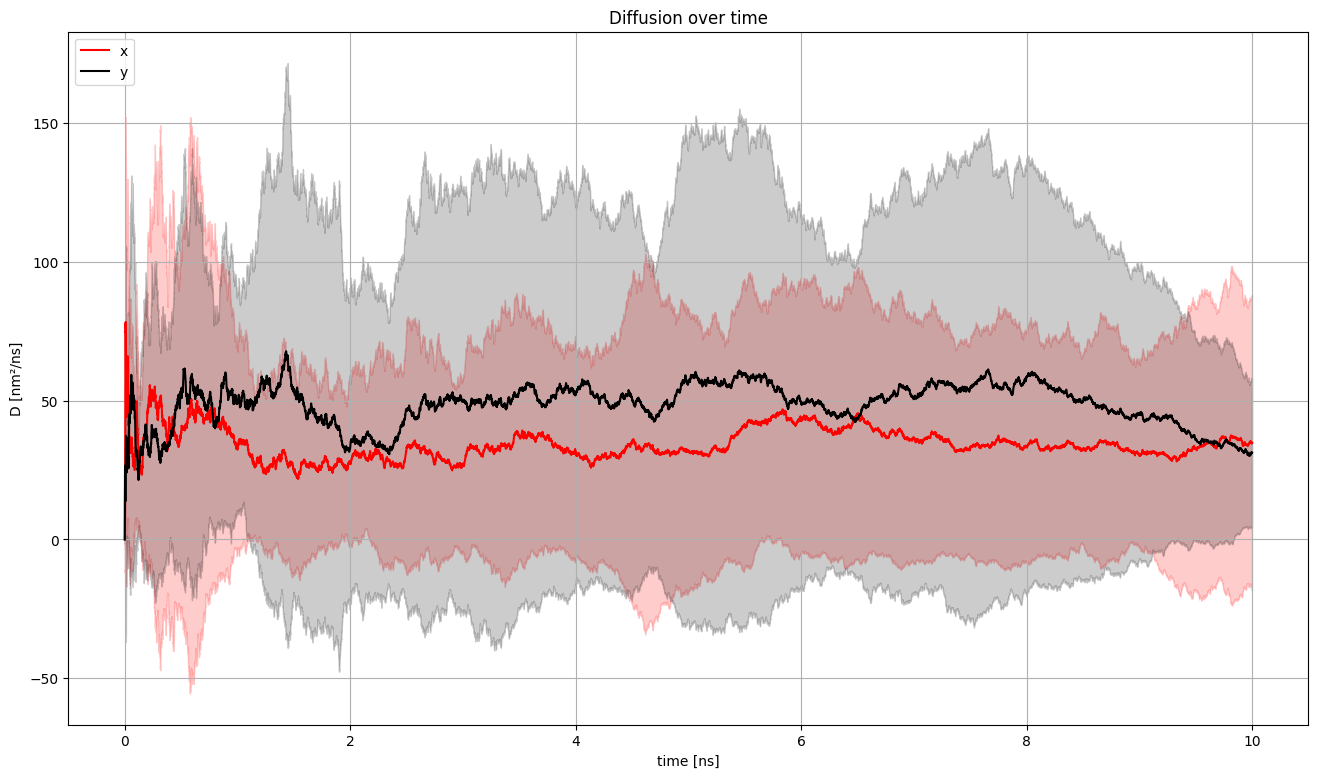

In [20]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(time,np.mean(d_r[:,0], axis=0), color = colours[0], label = 'x')
ax.plot(time,np.mean(d_r[:,1], axis=0), color = colours[1], label = 'y')

ax.fill_between(time,x_mean - x_std,x_mean + x_std, alpha=0.2, color = colours[0])
ax.fill_between(time,y_mean - y_std,y_mean + y_std, alpha=0.2, color = colours[1])

ax.set_xlabel('time [ns]')
ax.set_ylabel('D [nm²/ns]')
plt.title('Diffusion over time')
plt.grid()
plt.legend(loc='upper left')
plt.show()

In [25]:
d_r.shape

(20, 2, 10000001)

In [54]:
Gamma = sim.kB*sim.temp/(np.mean(d_r, axis=0)/avogadro)
Gamma.shape

(2, 10000001)

In [55]:
#g_x_mean = np.mean(Gamma[:,0], axis=0)
#g_y_mean = np.mean(Gamma[:,1], axis=0)

#g_x_std = np.std(Gamma[:,0], axis=0)
#g_y_std = np.std(Gamma[:,1], axis=0)

colours = ['r','k']

In [56]:
#g_x_mean

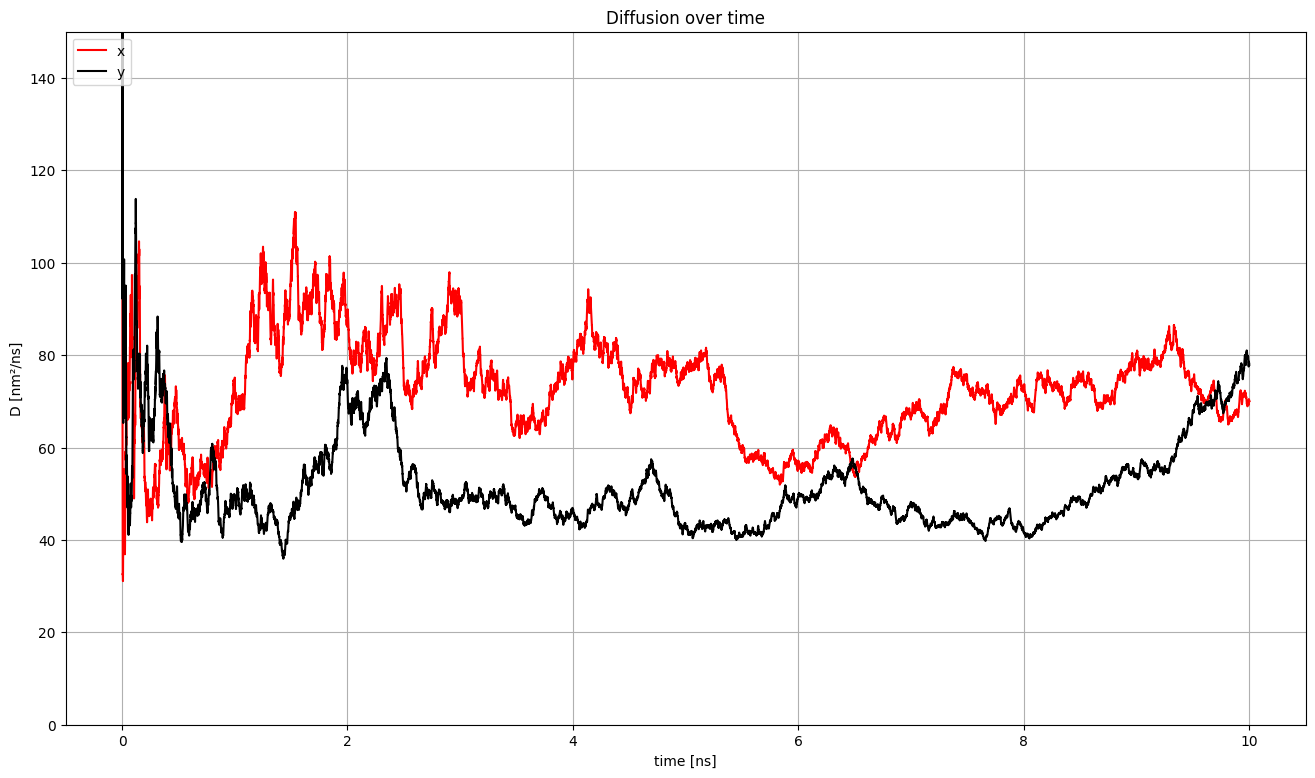

In [59]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(time,Gamma[0], color = colours[0], label = 'x')
ax.plot(time,Gamma[1], color = colours[1], label = 'y')

#ax.fill_between(time,g_x_mean - g_x_std,g_x_mean + g_x_std, alpha=0.2, color = colours[0])
#ax.fill_between(time,g_y_mean - g_y_std,g_y_mean + g_y_std, alpha=0.2, color = colours[1])

ax.set_ylim(0,150)

ax.set_xlabel('time [ns]')
ax.set_ylabel('D [nm²/ns]')
plt.title('Diffusion over time')
plt.grid()
plt.legend(loc='upper left')
plt.show()

In [60]:
class HardSpheres(Box):
    """
    A Box that implements the hard-spheres style particle system.
    """
    def __init__(self, box_size, n_Particles: int, boundary, rng_seed:int|None=None):
        """Initializing the HardSpheres Box-model.
        """
        super().__init__(box_size, n_Particles, boundary, rng_seed)
    
    

    def reflect(self) -> None:
        """Reflecting particles on the edges of the box, if the hull is touching\n
        """
        positive = self.particles_pos+self.particles_r[:,np.newaxis]
        negative = self.particles_pos-self.particles_r[:,np.newaxis]
        
        self.particles_vel[np.asarray(np.logical_and(positive > self.box_size, self.particles_vel > 0)).nonzero()] *= -1
        self.particles_vel[np.asarray(np.logical_and(negative < 0, self.particles_vel < 0)).nonzero()] *= -1
        self.particles_pos = np.where(np.logical_and(positive > self.box_size, self.particles_vel > 0),
                                      self.particles_pos-2*np.abs(positive - self.box_size[np.newaxis,:]), self.particles_pos)
        self.particles_pos = np.where(np.logical_and(negative < 0, self.particles_vel < 0), self.particles_pos+2*np.abs(negative), self.particles_pos)

    def single_collsision(self, collision) -> None:
        """Implements a single collision with time-warping. First the spheres are pushed back in time, until only the surfaces touch.
        Then a elastic collision with no energy-loss is performed, after which the time is warped forward again for the same amount of time
        with updated velocities.\n
        collision   : Array of length 2 with the indices of the colliding particles.
        """
        # defining re-used variables
        vel = self.particles_vel[collision[0]] - self.particles_vel[collision[1]]  # particles[i].vx-particles[j].vx
        v_x = vel[0]
        v_y = vel[1]

        r_x = self.distance_mat[collision[0],collision[1],0]
        r_y = self.distance_mat[collision[0],collision[1],1]
        
        R = self.combined_radii[collision[0],collision[1]]
        # angle between x-axis and line between particles
        if r_x == 0:
            phi = 0
        else:
            phi = np.arctan(r_y/r_x)
        
        #calculating the time needed to travel back in two steps:
        sqrt = 2*np.sqrt((r_x*v_x+r_y*v_y)**2-(v_x**2+v_y**2)*(r_x**2+r_y**2-R**2))
        
        delta_t = -1*(-2*(r_x*v_x+r_y*v_y) + sqrt)/(2*(v_x**2+v_y**2))
        
        # solving the quadratic equation results in two solutions (one positive and one negative), we want the negative solution, for backwards time-travel
        # We never enter this if statement though. Not sure wether necessary...
        if delta_t > 0:
            delta_t = -1*(-2*(r_x*v_x+r_y*v_y) - sqrt)/(2*(v_x**2+v_y**2))

        # rewind time to just outside of the collision
        self.move(dt = delta_t, particles = [collision[0],collision[1]])
        
        # only calculate once, used multiple times
        sin_phi = np.sin(phi)
        cos_phi = np.cos(phi)

        # Get the velocities of particles i and j as variables
        v1x, v1y = self.particles_vel[collision[0],0], self.particles_vel[collision[0],1]
        v2x, v2y = self.particles_vel[collision[1],0], self.particles_vel[collision[1],1]

        # Calculate the updated velocities using the provided formulas: https://hermann-baum.de/elastischer_stoss/
        # the tangental part stays the same, the normal part changes. This is done in transformed coordinates and then transformed directly back
        new_v1x = (v1x * sin_phi - v1y * cos_phi) * sin_phi + (v2x * cos_phi + v2y * sin_phi) * cos_phi
        new_v1y = (-v1x * sin_phi + v1y * cos_phi) * cos_phi + (v2x * cos_phi + v2y * sin_phi) * sin_phi
        new_v2x = (v2x * sin_phi - v2y * cos_phi) * sin_phi + (v1x * cos_phi + v1y * sin_phi) * cos_phi
        new_v2y = (-v2x * sin_phi + v2y * cos_phi) * cos_phi + (v1x * cos_phi + v1y * sin_phi) * sin_phi

        # Update the particles' velocities
        self.particles_vel[collision[0],0], self.particles_vel[collision[0],1] = new_v1x, new_v1y
        self.particles_vel[collision[1],0], self.particles_vel[collision[1],1] = new_v2x, new_v2y

        # finish this time_step, that was rewound previously
        self.move(dt = -delta_t, particles = [collision[0],collision[1]])

    def collide_all(self) -> None:
        # TODO implement multiple particle collisions
        """Collide all particles if they overlap. """
        self.calculate_distance_matrix()
        distance_abs_triangle = np.triu(self.distance_abs)
        # Find all the indices of pairs that collide. Only in the upper triangle to avoid double counting
        collisions = np.transpose(np.where(np.where(distance_abs_triangle == 0, np.inf, distance_abs_triangle) < self.combined_radii)) # shape: (n_collisions,2)
        # Check if any collisions are happening
        if collisions.shape[0] != 0:
            for i in range(collisions.shape[0]):
                self.single_collsision(collisions[i])


    def step(self, dt:float):
        """
        The implementation of one time-step of the Molecular Dynamics system.\n
        dt      : the time-step in ns
        """
        self.move(dt=dt)
        if self.boundary:
            # Using double reflect to avoid particles getting stuck inside the walls
            self.reflect()
            self.collide_all()
            self.reflect()
        else:
            self.collide_all()
            self.wrap_around()

In [61]:
class Infection(HardSpheres):
    """
    Infection Box-model with HardSpheres. There are three possible states each particle can be in: healthy (-1), infected (a number counting down to zero) and immunized (0). 
    These change throughout the simulation, but since every particle can only be in one state at a time,
    they are all stored in the same array (infection_state).
    """
    def __init__(self, box_size, n_Particles: int, breakthrough: float, infection_duration: int = 500, boundary: bool = True, rng_seed: int|None = None):
        super().__init__(box_size, n_Particles, boundary, rng_seed)
        """Initializing the Infection Model as a HardSpheres box.
        breakthrough        : nals
        infection_duration  : sadgf
        """
        self.infection_state        = np.zeros(n_Particles, dtype = int) - 1
        self.infection_breakthrough = breakthrough
        self.infection_duration     = infection_duration
    
    def initialize_infection(self, n_infected:int = 1, percent_immunized:float = 0) -> None:
        """Initialize the amount of people initially infected or immunized. Each can either be infected or immunized.\n
        n_infected          : absolute number of infected people. Must be above 0 and below n_particles.
        percent_immunized   : percentage between 0 and 1 for the amount of immunized people. Will be rounded up.        
        """
        if n_infected < 0 or n_infected > self.n_particles:
            print('Trying to initialize with invalid amount of infected people')
            return
        elif percent_immunized < 0 or percent_immunized > 1:
            print('Trying to initialize with an incorrect percentage of immunized people')
            return
        self.infection_state = np.zeros(self.n_particles, dtype = int) - 1
        
        n_immunized = int(math.ceil(percent_immunized*self.n_particles))

        indices_infected = self.rng.choice(self.n_particles, size=n_infected + n_immunized, replace=False)
        self.infection_state[indices_infected[:n_infected]] = 500
        self.infection_state[indices_infected[n_infected:]] = 0

    def collide_all(self) -> None:
        """Collide all particles if they overlap. Additionally infect other people. Overrides the function in HardSpheres."""
        self.calculate_distance_matrix()
        distance_abs_triangle = np.triu(self.distance_abs)
        # Find all the indices of pairs that collide. Only in the upper triangle to avoid double counting
        collisions = np.transpose(np.where(np.where(distance_abs_triangle == 0, np.inf, distance_abs_triangle) < self.combined_radii)) # shape: (n_collisions,2)
        # Check if any collisions are happening
        if collisions.shape[0] != 0:
            for i in range(collisions.shape[0]):
                self.single_collsision(collisions[i])
                infected = np.asarray(self.infection_state[collisions[i]] > 0).nonzero()[0]
                # Check wether only one of the participating spheres is currently infected. If both or none it doesn't matter.
                if infected.size == 1:
                    opp_index = collisions[i,np.mod(infected[0]+1,2)]
                    if self.infection_state[opp_index] == -1:
                        self.infection_state[opp_index] = 500
                    elif self.infection_state[opp_index] == 0 and self.rng.random() < self.infection_breakthrough:
                        self.infection_state[opp_index] = 500
                        
    def countdown_infection(self):
        """Reduce the infected time of all currently infected people. Overrides the function in HardSpheres."""
        self.infection_state = np.where(self.infection_state > 0, self.infection_state-1, self.infection_state)

    def step(self, dt:float):
        """
        The implementation of one time-step of the Molecular Dynamics system.\n
        dt      : the time-step in ns
        """
        self.move(dt=dt)
        if self.boundary:
            # Using double reflect to avoid particles getting stuck inside the walls
            self.countdown_infection()
            self.reflect()
            self.collide_all()
            self.reflect()
        else:
            self.countdown_infection()
            self.collide_all()
            self.wrap_around()




In [62]:
class Simulation:
    """Simulation class for everything related to simulating the particles in a box\n
    box         : The box object which should be simulated
    steps       : The number of integration steps to perform
    dt          : The length of one time step
    data_traj   : The trajectories of all particles
    """
    def __init__(self, box:Box, steps:int, dt, target_temp = 300) -> None:
        """Initializing the Simulation\n
    box         : The box object which should be simulated
    steps       : The number of integration steps to perform
    dt          : The length of one time step
    """
        self.box:Box = box
        self.steps = steps
        self.dt = dt
        self.target_temp = target_temp
        self.set_traj()

    def set_traj(self) -> None:
        """Initialize the trajectory-saving"""
        self.data_traj          = np.zeros((self.box.n_particles, 3, 2, self.steps+1))  
        self.distance_matrix    = np.zeros((self.box.n_particles, self.box.n_particles, self.steps+1))

        if type(self.box) == Infection:
            self.infection_states   = np.zeros((self.box.n_particles, self.steps+1), dtype=int)

        elif type(self.box) == LennardJones:
            self.pot_energy         = np.zeros((self.box.n_particles, self.box.n_particles, self.steps+1))
            self.kin_energy         = np.zeros((self.box.n_particles, self.steps+1))
            self.temps              = np.zeros((self.steps+1))

    def run(self) -> None:
        if type(self.box) == Infection:
            self.set_traj()
            # Save the initial configuration
            self.data_traj[:,0,:,0], self.data_traj[:,1,:,0], self.data_traj[:,2,:,0] = self.box.particles_pos, self.box.particles_vel, self.box.particles_acc

            self.box.calculate_distance_matrix()
            if self.box.boundary:
                self.distance_matrix[:,:,0] = self.box.distance_abs
            else:
                self.distance_matrix[:,:,0] = self.box.distance_abs_ghost

            self.infection_states[:,0]      = self.box.infection_state
            
            for i in tqdm(range(self.steps),ascii=True):
                # do MD and save pos, vel and acc
                self.box.step(self.dt)
                self.data_traj[:,0,:,i+1], self.data_traj[:,1,:,i+1], self.data_traj[:,2,:,i+1] = self.box.particles_pos, self.box.particles_vel, self.box.particles_acc
                
                self.box.calculate_distance_matrix()
                if self.box.boundary:
                    self.distance_matrix[:,:,i+1]   = self.box.distance_abs
                else:
                    self.distance_matrix[:,:,i+1]   = self.box.distance_abs_ghost
                
                self.infection_states[:,i+1]        = self.box.infection_state
        elif type(self.box) == HardSpheres:
            self.set_traj()
            # Save the initial configuration
            self.data_traj[:,0,:,0], self.data_traj[:,1,:,0], self.data_traj[:,2,:,0] = self.box.particles_pos, self.box.particles_vel, self.box.particles_acc

            self.box.calculate_distance_matrix()
            if self.box.boundary:
                self.distance_matrix[:,:,0] = self.box.distance_abs
            else:
                self.distance_matrix[:,:,0] = self.box.distance_abs_ghost

            
            for i in tqdm(range(self.steps),ascii=True):
                # do MD and save pos, vel and acc
                self.box.step(self.dt)
                self.data_traj[:,0,:,i+1], self.data_traj[:,1,:,i+1], self.data_traj[:,2,:,i+1] = self.box.particles_pos, self.box.particles_vel, self.box.particles_acc
                
                self.box.calculate_distance_matrix()
                if self.box.boundary:
                    self.distance_matrix[:,:,i+1]   = self.box.distance_abs
                else:
                    self.distance_matrix[:,:,i+1]   = self.box.distance_abs_ghost
                

        

